$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$


# Explanation of First-Generation QM Model

# Disclaimer

The author is not an NMR spectroscopist by training. Ultimately, I would like to understand, and be able to explain, the quantum mechanics behind the entire process of simulating an NMR spectrum. For now, here is a "recipe" of the steps to arrive at the spin Hamiltonian, and how its eigensolution can be used to calculate frequencies and intensities.

Two sources in particular enabled this:
1. Materials by Ilya Kuprov at SpinDynamics.org, particularly [Module I, Lecture 5](http://spindynamics.org/documents/sd_m1_lecture_05.pdf) and the Matlab code of [Module II, Lecture 05](http://spindynamics.org/documents/sd_m2_lecture_05.pdf) and [06](http://spindynamics.org/documents/sd_m2_lecture_06.pdf).
2. [Materials](http://www.users.csbsju.edu/~frioux/workinprogress.html#Spectroscopy) by Frank Rioux at St. John's University and College of St. Benedict. In particular, [*ABC Proton NMR Using Tensor Algebra*](http://www.users.csbsju.edu/~frioux/nmr/ABC-NMR-Tensor.pdf) was very helpful.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import sys

import numpy as np
from math import sqrt
from scipy.linalg import eigh
from scipy.sparse import kron, csc_matrix, csr_matrix, lil_matrix, bmat

# import bokeh.io
# import bokeh.plotting


In [3]:
home_path = os.path.abspath(os.path.join('..', '..', '..'))
if home_path not in sys.path:
    sys.path.append(home_path)

tests_path = os.path.abspath(os.path.join('..', '..', '..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

## Constructing the Hamiltonian From Scratch

Start with the Pauli matrices:
\begin{align}
\sigma_x = \begin{pmatrix}0& \frac{1}{2}\\ \frac{1}{2}&0\end{pmatrix}, 
\sigma_y = \begin{pmatrix}0& -\frac{i}{2}\\ \frac{i}{2}&0\end{pmatrix}, 
\sigma_z = \begin{pmatrix}\frac{1}{2}& 0\\ 0&-\frac{1}{2}\end{pmatrix}
\end{align}

plus the identity matrix $I = \begin{pmatrix}1&0\\0&1\end{pmatrix}$

In [4]:
sigma_x = np.array([[0, 1 / 2], [1 / 2, 0]])
sigma_y = np.array([[0, -1j / 2], [1j / 2, 0]])
sigma_z = np.array([[1 / 2, 0], [0, -1 / 2]])
unit = np.array([[1, 0], [0, 1]])

The required inputs are a list of frequencies $\nu_i$ and a matrix of $J_{ij}$ coupling constants:

In [5]:
v = [10.0, 20.0]
J = np.array([[0, 5], [5, 0]])


From these "ingredients", the steps for computing the spin Hamiltonian are:

### Step 1: Each spin gets its own $L_x$, $L_y$ and $L_z$ operators.

These are formed from Kronecker products between $\sigma_{x/y/z}$ and $I$ operators.

Each individual product, for n spins, uses 1$\sigma_{x/y/z}$ and (n - 1) $I$ operators. They all differ in where in the sequence the $\sigma_{x/y/z}$ operator is placed.

For 3 spins, and using $L_z$ for example:

\begin{align}
L_{z_1} &= \sigma_z \otimes I \otimes I\\
L_{z_2} &= I \otimes \sigma_z \otimes I\\
L_{z_3} &= I \otimes I \otimes \sigma_z
\end{align}


These operators are stored in a 4-D numpy array of shape (3, n, 2<sup>n</sup>, 2<sup>n</sup>). This can be visualized as a 2D matrix of 2D matrices, where every column contains a set of $L_{x/y/z}$ for one of the spins.
\begin{align}
L_{col} = \begin{pmatrix}
L_{x_1}& L_{x_2}&\dots & L_{x_n}\\ 
L_{y_1}& L_{y_2}&\dots & L_{y_n}\\
L_{z_1}& L_{z_2}&\dots & L_{z_n}
\end{pmatrix}
\end{align}

In [6]:
nspins = len(v)
L = np.empty((3, nspins, 2 ** nspins, 2 ** nspins), dtype=np.complex128)  
for n in range(nspins):
    Lx_current = 1
    Ly_current = 1
    Lz_current = 1

    for k in range(nspins):
        if k == n:
            Lx_current = np.kron(Lx_current, sigma_x)
            Ly_current = np.kron(Ly_current, sigma_y)
            Lz_current = np.kron(Lz_current, sigma_z)
        else:
            Lx_current = np.kron(Lx_current, unit)
            Ly_current = np.kron(Ly_current, unit)
            Lz_current = np.kron(Lz_current, unit)

    L[0][n] = Lx_current
    L[1][n] = Ly_current
    L[2][n] = Lz_current

### Step 2: Create the sums of cartesian products of $L$ operators.

The off-diagonal components of the Hamiltonian  $H$ require calculating Cartesian products of the $L$ operators. Python is a slow language, but numpy/sparse calculations use faster C/Fortran libraries. "Vectorizing" computations to use these math routines as much as possible (e.g. to avoid "for" loops and "if" statements) can dramatically speed up the computations, which otherwise become quite slow for 8+ spins. The fastest nmrsim computations pre-solve parts of the solutions (spin operators, their products, and transition matrices) as sparse matrices. 

All possible (Cartesian) products of spin operators can effectively be generated by taking the product of $L_{col}$ matrix with its transpose $L_{row}$:

\begin{align}
L_{row} = \begin{pmatrix}
L_{x_1}& L_{y_1}&L_{z_1}\\ 
L_{x_2}& L_{y_2}&L_{z_2}\\
\vdots&\vdots&\vdots\\
L_{x_n}& L_{y_n}&L_{z_n}
\end{pmatrix}
\end{align}

\begin{align}
L_{product}&= L_{row} \cdot L_{col} \\
&=\Tiny\begin{pmatrix}
L_{x_1}L_{x_1}+L_{y_1}L_{y_1}+L_{z_1}L_{z_1}&L_{x_1}L_{x_2}+L_{y_1}L_{y_2}+L_{z_1}L_{z_2}&\dots&L_{x_1}L_{x_n}+L_{y_1}L_{y_n}+L_{z_1}L_{z_n}\\
L_{x_2}L_{x_1}+L_{y_2}L_{y_1}+L_{z_2}L_{z_1}&L_{x_2}L_{x_2}+L_{y_2}L_{y_2}+L_{z_2}L_{z_2}&\dots&L_{x_2}L_{x_n}+L_{y_2}L_{y_n}+L_{z_2}L_{z_n}\\
\vdots& &\ddots& \\
L_{x_n}L_{x_1}+L_{y_n}L_{y_1}+L_{z_n}L_{z_1}&L_{x_n}L_{x_2}+L_{y_n}L_{y_2}+L_{z_n}L_{z_2}&\dots&L_{x_n}L_{x_n}+L_{y_n}L_{y_n}+L_{z_n}L_{z_n}\\
\end{pmatrix}
\end{align}





This may be computationally wasteful, since not many of these products are likely to be required. However, they can all be calculated "outside of Python", and then saved as sparse arrays for future retrieval, largely negating the computational expense.

How to accomplish this in numpy is not straightforward to a novice (such as the author of this notebook), but fortunately there's StackOverflow: 

https://stackoverflow.com/questions/47752324/matrix-multiplication-on-4d-numpy-arrays


In [7]:
L_T = L.transpose(1, 0, 2, 3)
Lproduct = np.tensordot(L_T, L, axes=((1, 3), (0, 2))).swapaxes(1, 2)

### Step 3: Add the Zeeman (on-diagonal) terms to the Hamiltonian.

\begin{align}
H_{Zeeman} = \sum_{i=1}^n \nu_i L_{z_i}
\end{align}

In [8]:
Lz = L[2]  # array of Lz operators
H = np.tensordot(v, Lz, axes=1)
H

array([[ 15.+0.j,   0.+0.j,   0.+0.j,   0.+0.j],
       [  0.+0.j,  -5.+0.j,   0.+0.j,   0.+0.j],
       [  0.+0.j,   0.+0.j,   5.+0.j,   0.+0.j],
       [  0.+0.j,   0.+0.j,   0.+0.j, -15.+0.j]])

### Step 4: Add the J-coupling (off-diagonal) terms to the Hamiltonian.

\begin{align}
H_J &= \sum_{i=1}^n \sum_{j=1}^n \frac{J_{ij}}{2} (L_{x_i}L_{x_j}+L_{y_i}L_{y_j}+L_{z_i}L_{z_j})\\
H &= H_{Zeeman} + H_J
\end{align}

The magical numpy calculation that achieves this looks a lot less scary than the math notation!

In [9]:
J = np.array(J)  # convert to numpy array first
scalars = 0.5 * J
H += np.tensordot(scalars, Lproduct, axes=2)
H

array([[ 16.25+0.j,   0.  +0.j,   0.  +0.j,   0.  +0.j],
       [  0.  +0.j,  -6.25+0.j,   2.5 +0.j,   0.  +0.j],
       [  0.  +0.j,   2.5 +0.j,   3.75+0.j,   0.  +0.j],
       [  0.  +0.j,   0.  +0.j,   0.  +0.j, -13.75+0.j]])

## Extracting Signal Frequencies and Intensities From the Hamiltonian

To simulate a "modern" NMR experiment, a 90° pulse and FID acquisition is simulated, followed by Fourier transform. This is the approach used in Kuprov's Matlab code, and should be the required approach for any experiment requiring a more elaborate pulse sequence. 

For a simple NMR spectrum, we can adopt a "continuous wave spectrometer" approach. We can find the resonance frequencies and their relative intensities directly from the spin Hamiltonian. The time-independent Schrodinger equation $H\Psi = E\Psi$ is solved for eigenvectors and corresponding eigenvalues. 

For each $\psi_i$, the eigenvectors are the coefficients $c_n$ for each pure spin state. For a two-spin system, for example,

$\psi_i = c_1\ket{\alpha\alpha} + c_2\ket{\alpha\beta} + c_3\ket{\beta\alpha} + c_4\ket{\beta\beta}$.

and the corresponding eigenvector would be \begin{bmatrix}c_1\\c_2\\c_3\\c_4\end{bmatrix}

For a one-spin system, the two states for "spin-up" ($\ \ket{\uparrow}$ or $\ket{\alpha}$) and for "spin-down" ($\ \ket{\downarrow}$ or $\ket{\beta}$) are represented by vectors $\begin{bmatrix}1\\0\end{bmatrix}$ and $\begin{bmatrix}0\\1\end{bmatrix}$, respectively. For "pure" multiple-spin states, their vectors are obtained by taking tensor products of these vectors. For example:

\begin{align}
\ket{\alpha\alpha} &=
\begin{bmatrix}1\\0\end{bmatrix}\otimes\begin{bmatrix}1\\0\end{bmatrix} = \begin{bmatrix}1\\0\\0\\0\end{bmatrix}
\\
\ket{\alpha\beta} &= \begin{bmatrix}1\\0\end{bmatrix}\otimes\begin{bmatrix}0\\1\end{bmatrix} = \begin{bmatrix}0\\1\\0\\0\end{bmatrix}
\\
\ket{\beta\alpha} &= \begin{bmatrix}0\\1\end{bmatrix}\otimes\begin{bmatrix}1\\0\end{bmatrix} = \begin{bmatrix}0\\0\\1\\0\end{bmatrix}
\\
\ket{\beta\beta} &= \begin{bmatrix}0\\1\end{bmatrix}\otimes\begin{bmatrix}0\\1\end{bmatrix} = \begin{bmatrix}0\\0\\0\\1\end{bmatrix}
\end{align}

A (coincidental?) consequence of this is that the index for $H$, expressed in binary form as a series of 0s and 1s, is the eigenvector for the associated pure spin state (cf. Rioux's *ABC Proton NMR Using Tensor Algebra*). 

Since allowed transitions change the total spin of a system by $\pm$ 1, this is analogous to transitions only being allowed between spin states whose binary indices only differ at one bit. In computing terms, if the Hamming weight of the two indices differ by exactly 1, the transition is allowed. 

Knowing this, we can create a transition probability matrix $T$, where $T_{ij} = 1$ if a transition between states $i$ and $j$ are allowed, and $0$ if not.

In [10]:
# function was optimized by only calculating upper triangle and then adding
# the lower.
n = 2 ** nspins
T = np.zeros((n, n))
for i in range(n - 1):
    for j in range(i + 1, n):
        if bin(i ^ j).count('1') == 1:
            T[i, j] = 1
T += T.T
T

array([[0., 1., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [0., 1., 1., 0.]])

The eigenvector solutions for the Hamiltonian include two pure states ("all-up/$\alpha$" and "all-down/$\beta$", plus mixed states. We can construct a matrix $V_{col}$ where each column of the matrix is an eigenvector solution, in their indexed order:

\begin{align}
V_{col} = \begin{pmatrix}
\ket{\psi_1} &\ket{\psi_2} &\dots &\ket{\psi_n}
\end{pmatrix}
=\begin{pmatrix}
\begin{bmatrix}c_1\\c_2\\\vdots\\c_n\end{bmatrix}_1
&\begin{bmatrix}c_1\\c_2\\\vdots\\c_n\end{bmatrix}_2
&\dots
&\begin{bmatrix}c_1\\c_2\\\vdots\\c_n\end{bmatrix}_n
\end{pmatrix}
\end{align}

and where its transpose $V_{row} = V_{col}^T$ has an eigenvector for each row:

\begin{align}
V_{row}=\begin{pmatrix}
\bra{\psi_1} \\
\bra{\psi_2} \\
\vdots\\
\bra{\psi_n} \\
\end{pmatrix}
=\begin{pmatrix}
\begin{bmatrix}c_1&c_2&\dots&c_n\end{bmatrix}_1\\
\begin{bmatrix}c_1&c_2&\dots&c_n\end{bmatrix}_2\\
\vdots\\
\begin{bmatrix}c_1&c_2&\dots&c_n\end{bmatrix}_n\\
\end{pmatrix}
\end{align}


The intensity matrix $I$ can be obtained by taking $V_{row}\cdot T \cdot V_{col}$ and squaring it element-wise, so that $I_{ij}$ is the relative probability of a transition between the $\psi_i$ and $\psi_j$ states. The difference in energy between the two states gives the frequency in Hz.

The numpy procedures to calculate (frequency, intensity) signals from the eigensolution of H is again rather magical:

In [11]:
E, V = np.linalg.eigh(H)
V = V.real
I = np.square(V.T.dot(T.dot(V)))
I_upper = np.triu(I)  # symmetry makes it possible to use only one half of the matrix for faster calculation
E_matrix = np.abs(E[:, np.newaxis] - E)
E_upper = np.triu(E_matrix)
combo = np.stack([E_upper, I_upper])
iv = combo.reshape(2, I.shape[0] ** 2).T
cutoff = 0.001  # an arbitrary cutoff where peaks below this intensity are filtered out of the solution
peaklist =  iv[iv[:, 1] >= cutoff]
peaklist

array([[ 6.90983006,  0.5527864 ],
       [18.09016994,  1.4472136 ],
       [23.09016994,  0.5527864 ],
       [11.90983006,  1.4472136 ]])

Currently the mplplot function requires a list of tuples. An easy way to convert is to make sure that this simulation is normalized in intensity for 2H:

In [12]:
from nmrsim.math import normalize_peaklist
normalized_plist = normalize_peaklist(peaklist, 2)
normalized_plist

[(6.9098300562505255, 0.276393202250021),
 (18.090169943749473, 0.7236067977499789),
 (23.090169943749473, 0.276393202250021),
 (11.909830056250525, 0.7236067977499789)]

In [13]:
from nmrsim.plt import mplplot

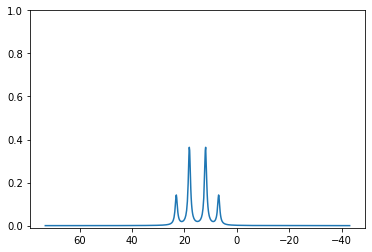

In [14]:
mplplot(normalized_plist);